In [28]:
%pip install Thermobar

In [2]:
# import core python packages that we'll use for plotting and data manipulation.
import sys
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import petthermotools as ptt 
import Thermobar as pt

alphaMELTS for Python files located.


In [3]:
## If using Mac run this cell **twice** 
import platform
if platform.system() == "Darwin" or platform.system() == "Linux":
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

# Magma decompression - comparing decompression models for OIBs and Arc dacites

Magma decompression calculations represent a common use of the MELTS algorithms, especially since the incorporation of a mixed H2O-CO2 solubility model in 2015 (Ghiorso and Gualda, 2015). One of the major advantages of running magma decompression calculations in a thermodynamic framework (i.e., MELTS) is the ability to track, not only exsolution of a fluid phase, but also the influence of decompression and degassing on the system temperature, crystallinity, and viscosity. We'll explore these parameters in more detail below, but first we need some data to work with!

First, let's load in some olivine-hosted melt inclusion data from Kilauea, Hawai'i (Wieser et al., 2022). This data is from the 2018 eruption and matrix glass analyses can be found in one of the other sheets in the excel file. Once you've ran the code below you should be able to see the structure of this data, including previous estimates of entrapment temperature (based on the liquid MgO content) and pressure (based of H2O-CO2 solubility).

In [4]:
Kilauea = pd.read_excel('Kilauea.xlsx', sheet_name='Olivine')
Kilauea = Kilauea.fillna(0.0)
Kilauea.head()

,Label,Na2O_Liq,Al2O3_Liq,P2O5_Liq,CaO_Liq,K2O_Liq,TiO2_Liq,SiO2_Liq,MgO_Liq,FeOt_Liq,MnO_Liq,H2O_Liq,CO2_Liq,SO2_Liq,MgO_Ol,SiO2_Ol,FeOt_Ol,Al2O3_Ol,CaO_Ol,MnO_Ol,NiO_Ol,P_bars
0,LLD_LL1_80,2.636,13.392,0.337,9.859,0.675,3.229,51.423,6.191,11.396,0.149,0.533371,0.025772,0.260182,40.67610,39.50335,19.94265,0.02705,0.24615,0.29030,0.19135,420.0
1,LLD_LL1_103,2.602,13.202,0.364,9.729,0.635,3.343,51.375,6.001,11.876,0.134,0.546140,0.021389,0.268108,40.16410,39.26485,21.20375,0.02400,0.23895,0.29335,0.18700,360.0
2,LLE_LL4_19b,2.303,13.523,0.378,10.594,0.429,2.550,50.793,7.432,11.337,0.179,0.500000,0.040292,0.232708,41.77670,39.36000,18.14420,0.03220,0.23040,0.25460,0.24260,640.0
3,LLE_LL4_19c,2.435,13.435,0.276,10.170,0.382,2.512,51.117,7.526,11.434,0.239,0.500000,0.022817,0.220636,41.93930,39.27305,18.17150,0.03355,0.22475,0.26455,0.24030,370.0
4,LLE_LL4_33b,2.435,13.747,0.347,10.397,0.496,2.758,51.649,6.020,11.338,0.282,0.500000,0.024655,0.214180,40.54345,39.10665,19.30270,0.02980,0.25095,0.27350,0.18230,420.0


So that we have a nice comparison to the relatively dry, tholeiitic magmas of Hawai'i, let's also load in a set of melt inclusion (in amphiboles and plagioclase, A1 and P1 'types' respectively) and groundmass glass data from the white pumice of the 1980 Mt St Helens eruption (Blundy and Cashman, 2005). You should be able to see that these samples have a reported H2O content, but no measured CO2 (although Jon Blundy did later detect, and measure CO2 - up to 0.04 wt% - in Mt St Helens melt inclusions).

In [5]:
# Melt inclusion and groundmass glass data from Mt St Helens (Blundy and Cashman, 2005)
StHelens = pd.read_excel('StHelens.xlsx', sheet_name='1980_WhitePumice')
StHelens = StHelens.fillna(0.0)
StHelens.head()

,sample,Type,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,H2O,Total
0,KCHB-4Aa,A1,68.05,0.33,12.96,2.72,0.12,0.98,1.95,5.60,1.93,4.63,99.26
1,KCHB-7Ab,A1,69.01,0.37,14.07,2.19,0.02,0.36,2.25,5.54,1.85,3.19,99.09
2,KCHB-8Aa,A1,70.19,0.35,14.70,2.52,0.03,0.34,2.24,6.51,1.72,1.83,100.43
3,KCHB-I IR,A1,65.81,0.51,15.03,2.13,0.00,0.37,2.35,5.65,2.44,4.92,99.2
4,KCHB-I IB',A1,69.71,0.21,14.15,2.48,0.00,0.45,2.23,6.39,2.03,2.66,100.29


Let's now create a TAS plot showing the differences between the Kilauea and Mt St Helens data. If you get to this point quickly and are waiting for us to move on load in the matrix glass data from Hawai'i as well (this can be found in a different sheet of the same excel file) and add that data to the plot.

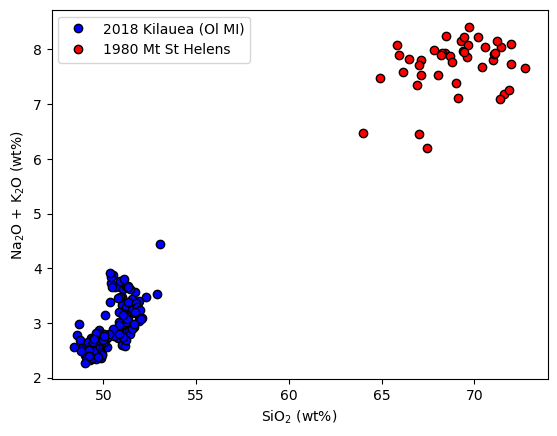

In [6]:
f, a = plt.subplots(1,1)
a.plot(Kilauea['SiO2_Liq'], Kilauea['Na2O_Liq'] + Kilauea['K2O_Liq'], 'ok', mfc = 'b', label = '2018 Kilauea (Ol MI)')
a.plot(StHelens['SiO2'], StHelens['Na2O'] + StHelens['K2O'], 'ok', mfc = 'r', label = '1980 Mt St Helens')
a.set_xlabel('SiO$_2$ (wt%)')
a.set_ylabel('Na$_2$O + K$_2$O (wt%)')
a.legend()

# Part 1 - Magma decompression at Kilauea

To start, let's focus on Kilauea. If you want to see how these calculations were used to help explain why some fissures of the 2018 eruption were more explosive then others, have a read through this paper (https://doi.org/10.1029/2021GC010046). 

For these calculations let's focus our simulations onto Fissure 8 (now called Ahu'aila'au), the fissure that was responsible for the majority of the lava volume erupted. Using Pandas, and a simple .loc operator, we can separate out all of the analyses from fissure 8:

In [7]:
F8 = Kilauea.loc[Kilauea['Label'].str.contains('LL8')].copy()
F8 = F8.reset_index(drop = True)
F8.head()

,Label,Na2O_Liq,Al2O3_Liq,P2O5_Liq,CaO_Liq,K2O_Liq,TiO2_Liq,SiO2_Liq,MgO_Liq,FeOt_Liq,MnO_Liq,H2O_Liq,CO2_Liq,SO2_Liq,MgO_Ol,SiO2_Ol,FeOt_Ol,Al2O3_Ol,CaO_Ol,MnO_Ol,NiO_Ol,P_bars
0,LLF_LL8_249a,2.201,12.885,0.246,11.233,0.404,2.422,51.013,7.666,11.333,0.214,0.5,0.000985,0.041279,42.460433,39.601867,17.768333,0.027833,0.286700,0.2565,0.223833,50.0
1,LLf_LL8_249b,2.176,12.879,0.244,11.084,0.405,2.376,51.167,7.728,11.374,0.188,0.5,0.018104,0.070177,42.460433,39.601867,17.768333,0.027833,0.286700,0.2565,0.223833,310.0
2,LLf_LL8_249c,2.296,13.028,0.219,10.541,0.503,2.536,51.446,7.682,11.337,0.152,0.5,0.031528,0.115493,42.460433,39.601867,17.768333,0.027833,0.286700,0.2565,0.223833,500.0
3,LLf_LL8_249d,2.248,13.068,0.249,10.816,0.434,2.519,51.232,7.683,11.338,0.158,0.5,0.023488,0.117043,42.460433,39.601867,17.768333,0.027833,0.286700,0.2565,0.223833,380.0
4,LLG_LL8_402a,2.242,12.019,0.261,10.214,0.340,2.166,49.730,11.073,11.331,0.254,0.5,0.002907,0.143986,45.678367,40.026900,12.737133,0.049600,0.230733,0.1789,0.375967,80.0


If we want to run a decompression calculation it probably makes sense to start out model at the highest pressure recorded by the melt inclusion dataset. We can extract that composition (and convert it into a Pandas Series) using the code below:

In [8]:
F8_start = F8.loc[F8['P_bars'] == F8['P_bars'].max(),:].squeeze()
F8_start

Label         LL8_610
Na2O_Liq        1.991
Al2O3_Liq      10.983
P2O5_Liq        0.192
CaO_Liq         9.581
K2O_Liq         0.337
TiO2_Liq        2.023
SiO2_Liq       49.279
MgO_Liq        13.734
FeOt_Liq       11.335
MnO_Liq         0.202
H2O_Liq           0.5
CO2_Liq      0.088678
SO2_Liq      0.124077
MgO_Ol       48.01215
SiO2_Ol       40.3695
FeOt_Ol       10.6914
Al2O3_Ol      0.05295
CaO_Ol         0.2257
MnO_Ol        0.15175
NiO_Ol         0.4021
P_bars         1050.0
Name: 17, dtype: object

Using PetThermoTools we can see what will have when we allow basaltic magma at Kilauea to decompress. For this calculation we'll assume we start at the liquidus at 1050 bars (the MagmaSat determined saturation pressure of this inclusion), we'll allow decompression to occur at a constant temperature. 

Some questions to think about as we move through the activity: What other thermal constraints could we empose on the system? Is an isothermal system realistic?

In [9]:
Kil_decompress = ptt.isothermal_decompression(Model = "MELTSv1.2.0", # rhyolite-MELTS v1.2.0 - updated H2O-CO2 solubility model
                                            bulk = F8_start, # composition defined above is our starting composition
                                            find_liquidus=True, # specify that we want to start at the liquidus 
                                            fO2_buffer="FMQ", # Impose a fO2 buffer
                                            P_start_bar=1050, # starting pressure (in bars)
                                            P_end_bar=50, # final pressure (in bars)
                                            dp_bar=20) # pressure step (in bars)


Inspect the results to see the composition of the fluid in wt% and molar proportions

In [10]:
Kil_decompress['fluid1'].head()

,H2O_Fl,CO2_Fl,X_H2O_mol_Fl,X_CO2_mol_Fl
0,NaN,NaN,NaN,NaN
1,2.530507,97.469493,0.059676,0.940324
2,2.575976,97.424024,0.060709,0.939291
3,2.623140,97.376860,0.061780,0.938220
4,2.672102,97.327898,0.062891,0.937109


Let's plot up how fluid composition and volume fraction change with pressure. In the 2-by-1 plot below plot the molar proportions of H2O and CO2 on one plot and the fluid volume fraction on the other plot. In PetThermoTools all variables can be accessed from a single DataFrame called 'All'. So, to access a particular variable you need to type **Kil_decompress['All'][variable]**. Run the two cells below to examine the output stucture and the different variables that are available. **Volume of the system and of each component is reported in cubic centimeters and is indicated by the lower case 'v'**.

In [11]:
Kil_decompress['All'].head()

,T_C,P_bar,mass_g,h_J,s_J/K,v_cm3,rho_kg/m3,log10(fO2),dvdp_cm3/bar,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq,mass_g_Liq,rho_kg/m3_Liq,v_cm3_Liq,g_J_Liq,h_J_Liq,s_J/K_Liq,cp_J/kg/K_Liq,dcpdt_J/K_Liq,dvdt_cm3/K_Liq,dpdt_bar/K_Liq,d2vdt2_cm3/K2_Liq,d2vdtdp_cm3/bar.K_Liq,d2vdp2_cm3/bar2_Liq,molwt_Liq,H2O_Fl,CO2_Fl,X_H2O_mol_Fl,X_CO2_mol_Fl,mass_g_Fl,rho_kg/m3_Fl,v_cm3_Fl,g_J_Fl,h_J_Fl,s_J/K_Fl,cp_J/kg/K_Fl,dcpdt_J/K_Fl,dvdt_cm3/K_Fl,dpdt_bar/K_Fl,d2vdt2_cm3/K2_Fl,d2vdtdp_cm3/bar.K_Fl,d2vdp2_cm3/bar2_Fl,molwt_Fl
0,1324.627019,1050.0,100.174575,-1.184117e+06,284.856454,37.225778,2691.000210,-6.935222,-0.000196,49.072560,2.014525,10.936990,0.0,1.739423,9.722363,11.287485,0.201154,13.676466,9.540863,1.982659,0.335588,0.191196,0.497905,0.088306,0.138660,100.174575,2691.000210,37.225778,-1.639254e+06,-1.184117e+06,284.856454,1542.026352,0.000155,0.002948,NaN,-4.043201e-09,-4.354757e-09,4.650897e-09,101.117609,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
1,1324.627019,1030.0,100.174610,-1.184183e+06,284.862396,37.232824,2690.491899,-6.936599,-0.000194,49.073061,2.014546,10.937101,0.0,1.739791,9.722148,11.287600,0.201156,13.676605,9.540961,1.982680,0.335592,0.191198,0.497884,0.087280,0.138688,100.173554,2690.749427,37.228868,-1.639312e+06,-1.184175e+06,284.856505,1542.029059,0.000155,0.002948,NaN,-3.986520e-09,-4.361128e-09,4.650880e-09,101.118893,2.530507,97.469493,0.059676,0.940324,0.001056,266.937892,0.003956,-17.270799,-7.858013,0.005891,726.230000,0.000156,0.000002,NaN,3.239882e-09,-2.005199e-09,5.993589e-09,42.459463
2,1324.627019,1010.0,100.174646,-1.184249e+06,284.868321,37.242214,2689.814470,-6.937976,-0.000191,49.073924,2.014581,10.937294,0.0,1.740174,9.722002,11.287798,0.201159,13.676845,9.541128,1.982714,0.335598,0.191201,0.497846,0.085534,0.138716,100.171793,2690.522547,37.231352,-1.639358e+06,-1.184227e+06,284.852383,1542.032795,0.000155,0.002948,NaN,-3.897352e-09,-4.372037e-09,4.650866e-09,101.121213,2.575976,97.424024,0.060709,0.939291,0.002853,262.681717,0.010862,-46.703097,-21.238217,0.015938,725.128800,0.000422,0.000006,NaN,8.992090e-09,-5.634864e-09,1.719285e-08,42.432604
3,1324.627019,990.0,100.174681,-1.184314e+06,284.874252,37.251841,2689.120278,-6.939353,-0.000187,49.074788,2.014617,10.937486,0.0,1.740557,9.721855,11.287997,0.201163,13.677086,9.541296,1.982749,0.335603,0.191204,0.497806,0.083787,0.138744,100.170028,2690.295827,37.233834,-1.639404e+06,-1.184280e+06,284.848227,1542.036510,0.000155,0.002947,NaN,-3.808354e-09,-4.382896e-09,4.650850e-09,101.123544,2.623140,97.376860,0.061780,0.938220,0.004653,258.389435,0.018007,-76.227961,-34.645928,0.026025,724.095774,0.000689,0.000010,NaN,1.506824e-08,-9.564735e-09,2.980234e-08,42.404781
4,1324.627019,970.0,100.174717,-1.184380e+06,284.880191,37.261721,2688.408225,-6.940730,-0.000183,49.075654,2.014652,10.937679,0.0,1.740941,9.721709,11.288196,0.201166,13.677328,9.541465,1.982784,0.335609,0.191208,0.497765,0.082040,0.138772,100.168261,2690.069275,37.236313,-1.639449e+06,-1.184332e+06,284.844036,1542.040209,0.000155,0.002947,NaN,-3.720037e-09,-4.393723e-09,4.650838e-09,101.125883,2.672102,97.327898,0.062891,0.937109,0.006455,254.060615,0.025408,-105.849776,-48.082441,0.036155,723.134469,0.000956,0.000014,NaN,2.148878e-08,-1.382331e-08,4.400349e-08,42.375934


In [12]:
Kil_decompress['All'].keys()

Index(['T_C', 'P_bar', 'mass_g', 'h_J', 's_J/K', 'v_cm3', 'rho_kg/m3',
       'log10(fO2)', 'dvdp_cm3/bar', 'SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq',
       'Cr2O3_Liq', 'Fe2O3_Liq', 'FeO_Liq', 'FeOt_Liq', 'MnO_Liq', 'MgO_Liq',
       'CaO_Liq', 'Na2O_Liq', 'K2O_Liq', 'P2O5_Liq', 'H2O_Liq', 'CO2_Liq',
       'Fe3Fet_Liq', 'mass_g_Liq', 'rho_kg/m3_Liq', 'v_cm3_Liq', 'g_J_Liq',
       'h_J_Liq', 's_J/K_Liq', 'cp_J/kg/K_Liq', 'dcpdt_J/K_Liq',
       'dvdt_cm3/K_Liq', 'dpdt_bar/K_Liq', 'd2vdt2_cm3/K2_Liq',
       'd2vdtdp_cm3/bar.K_Liq', 'd2vdp2_cm3/bar2_Liq', 'molwt_Liq', 'H2O_Fl',
       'CO2_Fl', 'X_H2O_mol_Fl', 'X_CO2_mol_Fl', 'mass_g_Fl', 'rho_kg/m3_Fl',
       'v_cm3_Fl', 'g_J_Fl', 'h_J_Fl', 's_J/K_Fl', 'cp_J/kg/K_Fl',
       'dcpdt_J/K_Fl', 'dvdt_cm3/K_Fl', 'dpdt_bar/K_Fl', 'd2vdt2_cm3/K2_Fl',
       'd2vdtdp_cm3/bar.K_Fl', 'd2vdp2_cm3/bar2_Fl', 'molwt_Fl'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Fluid Volume Fraction')

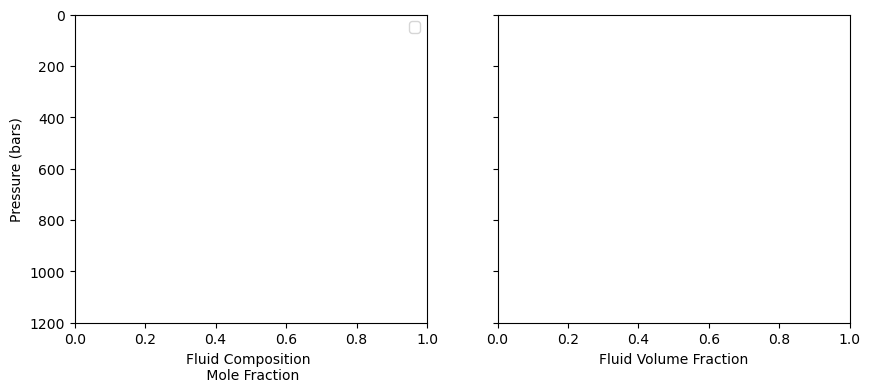

In [3]:
############## Use this cell block to plot the fluid composition and volume fraction ###############

f, a = plt.subplots(1,2, figsize = (10, 4), sharey=True)
a[0].plot()

a[0].set_ylim([1200,0])
a[0].legend()
a[0].set_xlabel('Fluid Composition \n Mole Fraction')
a[0].set_ylabel('Pressure (bars)')

a[1].plot()

a[1].set_ylim([1200,0])
a[1].set_xlabel('Fluid Volume Fraction')

In the graphs you've produced, what is the approximate composition of the fluid at: 

(i) 1000 bars; 

(ii) 100 bars? 

How would you describe the shape of the Fluid Volume Fraction curve and what does this indicate about the relative contribution of H2O and CO2 to the volume of the exsolved fluid?

# Part 2 - Magma Decompression at Mt St Helens & comparisons between OIBs and Arc magmas.

Let's turn our attention to the data from Mt St Helens. These pumice samples, from which the melt inclusion and groundmass data were collected, are all linked to the Plinian eruption of May 18th 1980. One of the obvious things that separates these dacites to the basalts of Hawai'i (other than their SiO2 contents) is their H2O abundance. Below we've provided some code that isolates a relatively 'primitive' plagioclase-hosted melt inclusion from the Blundy and Cashman (2005) dataset that we'll use as the starting composition for the following models.

In [14]:
# select a representative composition of the Mt St Helens white pumice. Here we've chosen a more mafic (~65 wt% SiO2) water rich inclusion.
WhitePumice = StHelens.loc[23]
WhitePumice

sample    006-IOAO
Type            PI
SiO2         64.91
TiO2          0.41
Al2O3        13.31
FeOt          2.78
MnO           0.02
MgO           0.71
CaO           1.95
Na2O          5.49
K2O           1.99
H2O           6.38
Total        98.27
Name: 23, dtype: object

Using the same function that we used in the Kilauea example above we can now run decompression calculations for the Mt St Helens magma. Other than the 'bulk' variable (i.e., the composition of our system), what other parameters do you think we might want to change? 

**i.e., other than their major element chemistry (including H2O) what separates arc lavas from those found in ocean island or mid-ocean ridge settings.**

In [15]:
############## Fill in the blank kwargs (replace the ...) - what separates arc magmas from OIBs? ###############
Helens_decompress = ptt.isothermal_decompression(Model="MELTSv1.2.0", 
                                                bulk=WhitePumice, 
                                                find_liquidus=True, 
                                                fO2_buffer="FMQ", 
                                                fO2_offset=..., 
                                                P_start_bar=2000, 
                                                P_end_bar=50, 
                                                dp_bar=20, 
                                                H2O_init = np.array([2,4,6,8]),
                                                CO2_init = 0.025, 
                                                fluid_sat = True, 
                                                label = 'H2O')

**Let's examine the results again**

In [16]:
Helens_decompress.keys()

dict_keys(['H2O = 2.0 wt%', 'H2O = 4.0 wt%', 'H2O = 6.0 wt%', 'H2O = 8.0 wt%'])

In [17]:
Helens_decompress['H2O = 8.0 wt%'].keys()

dict_keys(['Conditions', 'liquid1', 'liquid1_prop', 'fluid1', 'fluid1_prop', 'spinel1', 'spinel1_prop', 'plagioclase1', 'plagioclase1_prop', 'All', 'PhaseList', 'mass_g', 'volume_cm3', 'rho_kg/m3', 'Input'])

In [18]:
Helens_decompress['H2O = 8.0 wt%']['fluid1'].head()

,H2O_Fl,CO2_Fl,X_H2O_mol_Fl,X_CO2_mol_Fl
0,98.818486,1.181514,0.995133,0.004867
1,99.164899,0.835101,0.996567,0.003433
2,99.373409,0.626591,0.997427,0.002573
3,99.505279,0.494721,0.997970,0.002030
4,99.593903,0.406097,0.998335,0.001665


**Using the plot below, loop through the results dictionary to plot the mole fraction of H2O in the fluid for each decompression model**

In [5]:
# set up figure layout
f, a = plt.subplots(1,1, figsize = (4,3.5))

#### loop through main Dictionary ####
for key in Helens_decompress:
    # extract individial calculations
    res = Helens_decompress[key]

    # plot fluid chemistry vs pressure
    a.plot(...)

a.legend()

a.set_xlabel('X$_{H2O}$')
a.set_ylabel('Pressure (bar)')

f.tight_layout()

Let's compare the results from Kilauea and Mt St Helens (using the 6 wt% H2O model). **Plot up the Fluid Volume Fraction of the two models against each other. In addition, use Thermobar to calculate the viscosity of the magma during magma ascent towards the surface. An example of how to do this is shown for Kilauea.** Note, there is a module that allows you to calculate the viscosity of magmas (using the Giordano 2008 model) in alphaMELTS for Python, but using the Thermobar functions is also an incredibly easy way to calculate this parameter.

In [6]:
Vis_Kilauea = pt.calculate_viscosity_giordano_2008(liq_comps=Kil_decompress['liquid1'],
                                                  T=Kil_decompress['All']['T_C'] + 273.15)
Vis_Kilauea.head()

In [7]:
############## Fill in the blank kwargs (replace the ...) - what separates arc magmas from OIBs? ###############
Vis_Helens = pt.calculate_viscosity_giordano_2008(...)
Vis_Helens.head()

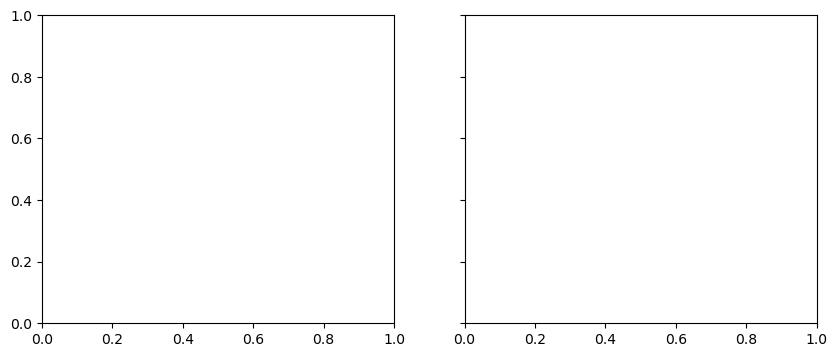

In [8]:
f, a = plt.subplots(1,2, figsize = (10, 4), sharey=True)
a[0].plot(Vis_Kilauea['logn_melt'],
          Kil_decompress['All']['P_bar'], '-k', label = 'Kilauea')
a[0].plot(Vis_Helens['logn_melt'],
          Helens_decompress['H2O = 6.0 wt%']['All']['P_bar'], '-r', label = 'Helens')

a[0].set_ylim([3200,0])
a[0].legend()
a[0].set_xlabel('log$_{10}(\eta)$ (Pa.s)')
a[0].set_ylabel('Pressure (bars)')

a[1].plot(Kil_decompress['volume_cm3']['fluid1']/Kil_decompress['volume_cm3'].sum(axis = 1),
          Kil_decompress['All']['P_bar'], '-k')
a[1].plot(Helens_decompress['H2O = 6.0 wt%']['volume_cm3']['fluid1']/Helens_decompress['H2O = 6.0 wt%']['volume_cm3'].sum(axis = 1),
          Helens_decompress['H2O = 6.0 wt%']['All']['P_bar'], '-r')

a[1].set_ylim([3200,0])
a[1].set_xlabel('Fluid Volume Fraction')

What is the major differences between to the two systems? How might this relate to changes in eruption styles?

# Part 3 - Isothermal vs Isentropic decompression

With many functions in PetThermoTools you can specify variables such as fO2, Fe-redox, H2O, and CO2 contents separately to the main 'bulk' composition that you provide. Furthermore, you can specify multiple values for these variables and PetThermoTools will run a calculation for each value specified. 

In this case, let's specify a range of different melt inclusion CO2 contents (this can easily be done using numpy) adding variable amounts of CO2 to the starting composition and run multiple degassing models simultaneously. Plot up the results below, how does increasing the initial magma CO2 content affect the degassing path? How does it influence other variables such as the magma temperature and/or crystal content?

In [31]:
# Use the same function as above to run the degassing calculations
Helens_decompress_CO2 = ptt.isothermal_decompression(Model="MELTSv1.2.0", 
                                                bulk=WhitePumice,
                                                find_liquidus=True, 
                                                fO2_buffer="FMQ", 
                                                fO2_offset= 1.5, # Don't forget to set an fo2 buffer
                                                P_start_bar=3500, 
                                                P_end_bar=50, 
                                                dp_bar=20,
                                                label="CO2",
                                                CO2_init = ...)

In [10]:
a = {'A': 11,
     'B': 12}

for j, key in enumerate(a):
    print(key)
    print(j)

0
A
1
B


In [9]:
# Define Viridis colormap
cmap = plt.get_cmap('viridis_r')

# Get n equally spaced values from the colormap
colors = [cmap(i) for i in np.linspace(0, 0.8, len(Helens_decompress_CO2))]

f, a = plt.subplots(1,2, figsize = (10, 4), sharey=True)
for j, key in enumerate(Helens_decompress_CO2):
    a[0].plot(...) 

    a[1].plot(...)

a[0].set_ylim([3600,0])
a[0].set_xlabel('Fluid Composition \n Mole Fraction')
a[0].set_ylabel('Pressure (bars)')

a[1].set_ylim([3600,0])
a[1].legend(fontsize = 6)
a[1].set_xlabel('Fluid Volume Fraction')

In addition to the fluid composition and fluid volume fraction there are a number of other variables that are interesting to consider during decompression calculations. First, we can think about how the temperature of the system changes. Obviously for an isothermal model this is quite straightforward, but is that realistic in nature? Second, we can consider not just the mass or volume of fluid formed, but also the mass of solid material crystallizing. What factors might drive crystallization in a degassing magma - what affect might this have on the rheological properties of the ascending melt?

To start, let's consider the mass fractions and temperature of the models that we just run. **Here I'm just plotting an example of the 0.02 wt% CO2 model, see what the graphs look like for the other models:**

In [33]:
# Access mass of system components & calculate liquid, solid and fluid mass fractions
mass_total = Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['mass_g']
mass_frac_Liq = Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['mass_g_Liq']/mass_total
mass_frac_Fl = Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['mass_g_Fl']/mass_total
mass_frac_Sol = 1 - mass_frac_Liq - mass_frac_Fl

Text(0.5, 0, 'Mass Fraction')

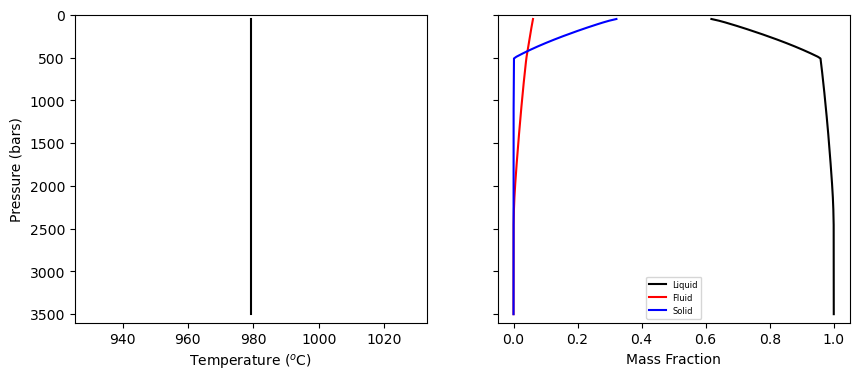

In [34]:
# plot temperature vs pressure and liquid, fluid, and solid mass fraction vs depth
f, a = plt.subplots(1,2, figsize = (10, 4), sharey=True)
a[0].plot(Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['T_C'], 
          Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['P_bar'], '-k')

a[0].set_ylim([3600,0])
a[0].set_xlabel('Temperature ($^{o}$C)')
a[0].set_ylabel('Pressure (bars)')
          
a[1].plot(mass_frac_Liq, Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['P_bar'], '-k', label = 'Liquid')
a[1].plot(mass_frac_Fl, Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['P_bar'], '-r', label = 'Fluid')
a[1].plot(mass_frac_Sol, Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['P_bar'], '-b', label = 'Solid')

a[1].set_ylim([3600,0])
a[1].legend(fontsize = 6)
a[1].set_xlabel('Mass Fraction')


One of the things that we can easily do in PetThermoTools is apply an isentropic (constant entropy) rather than isothermal (constant temperature) constraint on our system. If magmas decompress (or ascend) adibatically - that is, without exchanging heat energy with their surroundings - could this represent a more realistic scenario?

To run isentropic decompression models all that we need to do is replace the **ptt.isothermal_decompression()** function with **ptt.isentropic_decompression()**. All key-word arguments in the function remain the same!

In [35]:
# Run isentropic decompression models
Helens_decompress_CO2_isen = ptt.isentropic_decompression(Model="MELTSv1.2.0", 
                                                bulk=WhitePumice,
                                                find_liquidus=True, 
                                                fO2_buffer="FMQ", 
                                                fO2_offset=1.5,
                                                P_start_bar=3500, 
                                                P_end_bar=50, 
                                                dp_bar=20,
                                                label="CO2",
                                                CO2_Liq = np.array([0.005,0.01,0.02,0.04,0.1]))


**As we did for the isothermal models above, have a go at calculating the mass fractions of fluid, liquid, and solid at each step of the model. Plot up these results, and the temperature of the system, against the isothermal models. What is different? What causes the temperature variations during decompression?**

In [38]:
############## Calculate mass of system components & calculate liquid, solid and fluid mass fractions ###############
isen_mass_total = Helens_decompress_CO2_isen['CO2 = 0.02 wt%']['All']['mass_g']
isen_mass_frac_Liq = Helens_decompress_CO2_isen['CO2 = 0.02 wt%']['All']['mass_g_Liq']/isen_mass_total
isen_mass_frac_Fl = Helens_decompress_CO2_isen['CO2 = 0.02 wt%']['All']['mass_g_Fl']/isen_mass_total
isen_mass_frac_Sol = 1 - isen_mass_frac_Liq - isen_mass_frac_Fl

In [11]:
############## plot temperature vs pressure and liquid, fluid, and solid mass fraction vs depth ###############
f, a = plt.subplots(1,2, figsize = (10, 4), sharey=True)
a[0].plot(...)

a[0].set_ylim([3600,0])
a[0].legend(fontsize = 6)
a[0].set_xlabel('Temperature ($^{o}$C)')
a[0].set_ylabel('Pressure (bars)')
          
a[1].plot(...)

a[1].set_ylim([3600,0])
a[1].legend(fontsize = 6)
a[1].set_xlabel('Mass Fraction')


# Extra material: change in chemistry and viscosity of ascending magmas

In the previous calculations we've shown that decompression - if equilibrium is maintained - can cause ~40% crystallization of the magma (by mass). What is the influence of this crystallization on the magma chemistry and viscosity during ascent?

Plot up the liquid chemistry predicted by the decompression models against the melt inclusions and groundmass glass data from the white pumice (use **StHelens.loc[StHelens['Type'] == "GM", 'SiO2']** to access the SiO2 content of the groundmass glass). Start with a TAS plot, but also try other combinations of elements/oxides.

Text(0, 0.5, 'Na$_2$O + K$_2$O (wt%)')

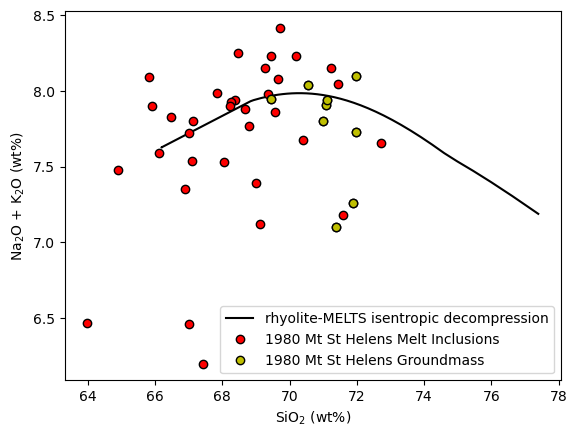

In [40]:
f, a = plt.subplots(1,1)
a.plot(Helens_decompress_CO2_isen['CO2 = 0.02 wt%']['All']['SiO2_Liq'],
        Helens_decompress_CO2_isen['CO2 = 0.02 wt%']['All']['K2O_Liq'] + Helens_decompress_CO2_isen['CO2 = 0.02 wt%']['All']['Na2O_Liq'],
        '-k', label = 'rhyolite-MELTS isentropic decompression')
a.plot(StHelens['SiO2'], StHelens['Na2O'] + StHelens['K2O'], 'ok', mfc = 'r', label = '1980 Mt St Helens Melt Inclusions')
a.plot(StHelens.loc[StHelens['Type'] == "GM", 'SiO2'], 
        StHelens.loc[StHelens['Type'] == "GM", 'Na2O'] + StHelens.loc[StHelens['Type'] == "GM", 'K2O'], 'ok', 
        mfc = 'y', label = '1980 Mt St Helens Groundmass')

a.legend()
a.set_xlabel('SiO$_2$ (wt%)')
a.set_ylabel('Na$_2$O + K$_2$O (wt%)')

One of the major benefits of PetThermoTools is that the results can be directly used in other Python packages. As an example we can use Thermobar to calculate the melt viscosity at each step of the model, with no data manipulation required.

In [41]:
import Thermobar as pt
Vis = pt.calculate_viscosity_giordano_2008(liq_comps=Helens_decompress_CO2_isen['CO2 = 0.02 wt%']['All'],
                                                  T=Helens_decompress_CO2_isen['CO2 = 0.02 wt%']['All']['T_C'] + 273.15)


Plot up the viscosity and SiO2 content of the melt against depth. What implications might these results have for the dynamics of magma ascent?

Text(0, 0.5, 'Pressure (bars)')

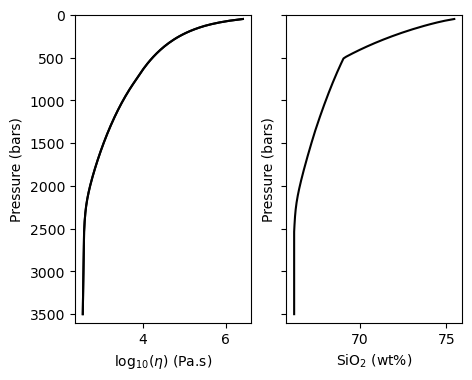

In [42]:
f, a = plt.subplots(1,2, figsize = (5, 4), sharey=True)
a[0].plot(Vis['logn_melt'], 
          Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['P_bar'], '-k')

a[0].set_ylim([3600,0])
a[0].set_xlabel('log$_{10}(\eta)$ (Pa.s)')
a[0].set_ylabel('Pressure (bars)')

a[1].plot(Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['SiO2_Liq'], 
          Helens_decompress_CO2['CO2 = 0.02 wt%']['All']['P_bar'], '-k')

a[1].set_ylim([3600,0])
a[1].set_xlabel('SiO$_2$ (wt%)')
a[1].set_ylabel('Pressure (bars)')